In [1]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
from autofeatselect import CorrelationCalculator, FeatureSelector, AutoFeatureSelect
import lazypredict
from lazypredict.Supervised import LazyRegressor
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer
from scipy.stats import skew

In [2]:
#import 2018's data for United Airlines
df_ua_2018 = pd.read_csv('ua_2018.csv')

In [3]:
n_jobs = -1
random_state = 42
seed = 24

### Flight Counts

In [4]:
count_total = len(df_ua_2018)
count_cancelled = len(df_ua_2018[df_ua_2018['Cancelled']==1])
count_diverted = len(df_ua_2018[df_ua_2018['Diverted']==1])

print('Total:', count_total)
print('Cancelled:', count_cancelled)
print('Diverted:', count_diverted)


Total: 621565
Cancelled: 4903
Diverted: 1747


In [5]:
#remove cancelled and diverted fligts
df_ua_2018 = df_ua_2018[(df_ua_2018['Cancelled']==0) & (df_ua_2018['Diverted']==0)]

In [6]:
count_delayed = len(df_ua_2018[(df_ua_2018['ArrDel15']==1)])
count_ontime = len(df_ua_2018[(df_ua_2018['ArrDel15']==0)])
print('Delayed:', count_delayed)
print('On-time:', count_ontime)

Delayed: 119644
On-time: 495271


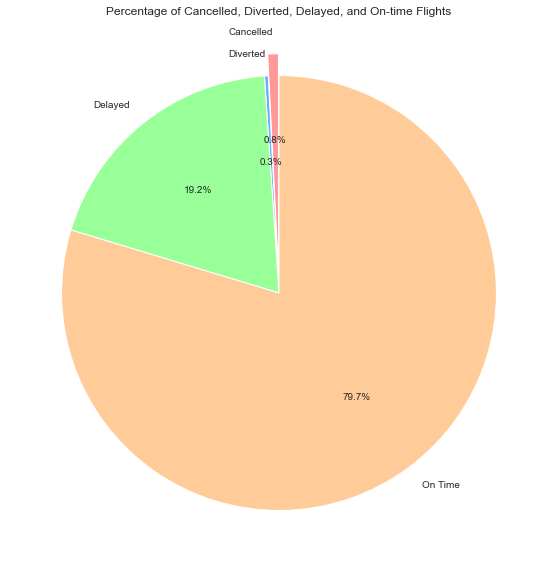

In [7]:
# Calculate percentages
percentage_cancelled = (count_cancelled / count_total) * 100
percentage_diverted = (count_diverted / count_total) * 100
percentage_delay = (count_delayed / count_total) * 100
percentage_ontime = (count_ontime / count_total) * 100

# Labels for the sections
labels = ['Cancelled', 'Diverted', 'Delayed', 'On Time']

# Values for each section
sizes = [percentage_cancelled, percentage_diverted, percentage_delay, percentage_ontime]

# Colors for each section
colors = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99']

# Exploding the Cancelled section
explode = (0.1, 0, 0, 0)
# Set the figure size
plt.figure(figsize=(10, 10))
# Create a pie chart
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, explode=explode)
plt.title('Percentage of Cancelled, Diverted, Delayed, and On-time Flights')
plt.show()

### Arrival Delays

In [8]:
arr_delay = df_ua_2018[df_ua_2018['ArrDel15']==1]
dep_delay_count = len(arr_delay[arr_delay['DepDel15']==1])
dep_ontime_count = len(arr_delay[arr_delay['DepDel15']==0])
print('Arrival Delays - Departure Delay:', dep_delay_count)
print('Arrival Delays - Departure On-time:', dep_ontime_count)

Arrival Delays - Departure Delay: 87693
Arrival Delays - Departure On-time: 31951


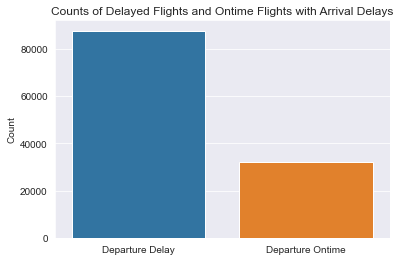

In [9]:
# Create a bar plot
categories = ['Departure Delay', 'Departure Ontime']
counts = [dep_delay_count, dep_ontime_count]

sns.barplot(x=categories, y=counts)
plt.title('Counts of Delayed Flights and Ontime Flights with Arrival Delays')
plt.ylabel('Count')
plt.show()

### Average Delays by Month

In [10]:
df_ua_2018.columns

Index(['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate',
       'Reporting_Airline', 'Tail_Number', 'Flight_Number_Reporting_Airline',
       'Origin', 'Dest', 'CRSDepTime', 'DepTime', 'DepDelay',
       'DepDelayMinutes', 'DepDel15', 'DepartureDelayGroups', 'DepTimeBlk',
       'TaxiOut', 'WheelsOff', 'WheelsOn', 'TaxiIn', 'CRSArrTime', 'ArrTime',
       'ArrDelay', 'ArrDelayMinutes', 'ArrDel15', 'ArrivalDelayGroups',
       'ArrTimeBlk', 'Cancelled', 'CancellationCode', 'Diverted',
       'CRSElapsedTime', 'ActualElapsedTime', 'AirTime', 'Flights', 'Distance',
       'DistanceGroup', 'CarrierDelay', 'WeatherDelay', 'NASDelay',
       'SecurityDelay', 'LateAircraftDelay', 'DivAirportLandings'],
      dtype='object')

In [11]:
delays = df_ua_2018[['Month',
                     'CarrierDelay', 
                     'WeatherDelay', 
                     'NASDelay',
                     'SecurityDelay', 
                     'LateAircraftDelay']]

In [12]:
delays_groupby_month = delays.groupby('Month').mean()
delays_groupby_month

,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
Month,,,,,
1,2.20,0.72,2.71,0.00,2.99
2,2.04,0.69,3.51,0.01,2.82
3,2.34,0.47,3.04,0.00,3.27
4,2.52,0.47,3.52,0.00,4.16
5,3.12,0.95,5.24,0.00,5.66
6,3.83,0.96,4.96,0.00,7.61
7,4.23,1.14,4.86,0.00,8.07
8,4.59,1.50,6.71,0.00,9.10
9,2.81,0.90,4.10,0.00,4.26


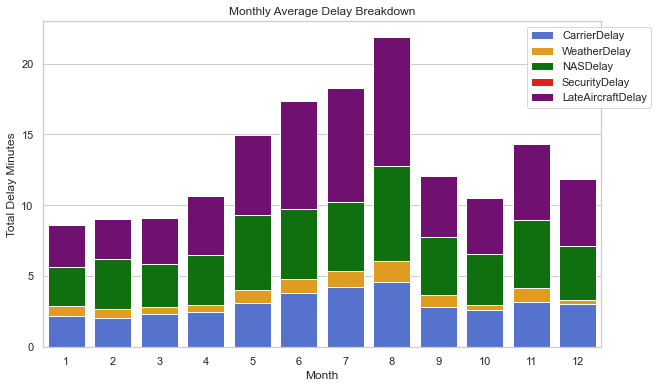

In [13]:
# Use Seaborn to create a bar plot
plt.figure(figsize=(10, 6))
sns.set(style='whitegrid')
sns.barplot(data=delays_groupby_month, x=delays_groupby_month.index, y='CarrierDelay', label='CarrierDelay', color='royalblue')
sns.barplot(data=delays_groupby_month, x=delays_groupby_month.index, y='WeatherDelay', label='WeatherDelay', bottom=delays_groupby_month['CarrierDelay'], color='orange')
sns.barplot(data=delays_groupby_month, x=delays_groupby_month.index, y='NASDelay', label='NASDelay', bottom=delays_groupby_month['CarrierDelay'] + delays_groupby_month['WeatherDelay'], color='green')
sns.barplot(data=delays_groupby_month, x=delays_groupby_month.index, y='SecurityDelay', label='SecurityDelay', bottom=delays_groupby_month['CarrierDelay'] + delays_groupby_month['WeatherDelay'] + delays_groupby_month['NASDelay'], color='red')
sns.barplot(data=delays_groupby_month, x=delays_groupby_month.index, y='LateAircraftDelay', label='LateAircraftDelay', bottom=delays_groupby_month['CarrierDelay'] + delays_groupby_month['WeatherDelay'] + delays_groupby_month['NASDelay'] + delays_groupby_month['SecurityDelay'], color='purple')

plt.title('Monthly Average Delay Breakdown')
plt.xlabel('Month')
plt.ylabel('Total Delay Minutes')
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1))
plt.show()

### Flight Count by Month

In [14]:
flight_count = df_ua_2018[['Month','Flight_Number_Reporting_Airline']]
count_groupby_month = flight_count.groupby('Month').count()

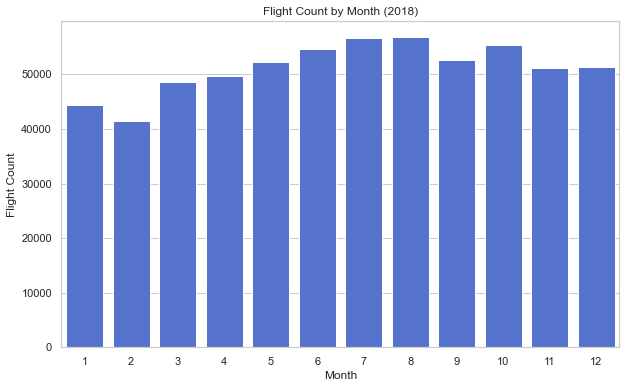

In [15]:
# Create a bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.set(style='whitegrid')
sns.barplot(x=count_groupby_month.index, y='Flight_Number_Reporting_Airline', data=count_groupby_month, color='royalblue')

plt.title('Flight Count by Month (2018)')
plt.xlabel('Month')
plt.ylabel('Flight Count')
plt.show()

### Correlation Between Flight Counts and Delays

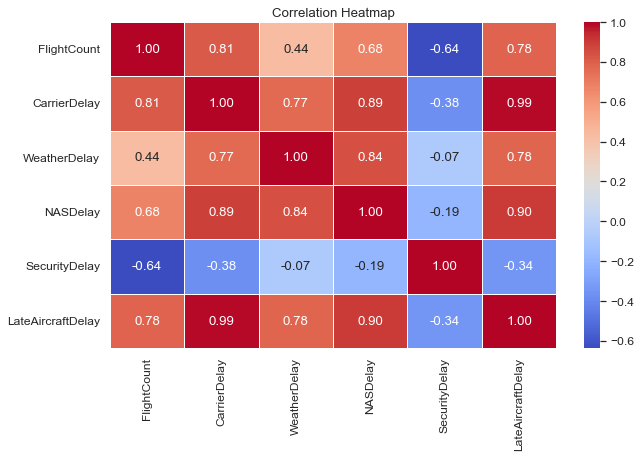

In [16]:
delays_count = pd.merge(count_groupby_month, delays_groupby_month, on='Month').rename(columns={'Flight_Number_Reporting_Airline': 'FlightCount'})
delays_count_corr = delays_count.corr()
# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 6))
sns.set(font_scale=1.1)
sns.heatmap(delays_count_corr, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")

plt.title('Correlation Heatmap')
plt.show()

### Calculate Minutes between Wheels Off and Wheels On

In [17]:
# Convert the three or four digits to 'hh:mm' format
df_ua_2018['WheelsOff_time'] = df_ua_2018['WheelsOff'].apply(lambda x: f'{x // 100:02d}:{x % 100:02d}')
df_ua_2018['WheelsOn_time'] = df_ua_2018['WheelsOn'].apply(lambda x: f'{x // 100:02d}:{x % 100:02d}')

# Calculate the time difference in minutes
df_ua_2018['WheelsOff_time'] = pd.to_datetime(df_ua_2018['WheelsOff_time'], format='%H:%M')
df_ua_2018['WheelsOn_time'] = pd.to_datetime(df_ua_2018['WheelsOn_time'], format='%H:%M')
   

In [18]:
# Calculate the time difference in minutes
df_ua_2018['TimeDifferenceMinutes_wheels'] = (df_ua_2018['WheelsOn_time'] - df_ua_2018['WheelsOff_time']).dt.total_seconds() / 60
df_ua_2018['TimeDifferenceMinutes_wheels'] = df_ua_2018['TimeDifferenceMinutes_wheels'].apply(lambda x: x + 24 * 60 if x < 0 else x)

In [19]:
# check the calculated results
df_ua_2018[['WheelsOff','WheelsOn','WheelsOff_time','WheelsOn_time','TimeDifferenceMinutes_wheels']] 

,WheelsOff,WheelsOn,WheelsOff_time,WheelsOn_time,TimeDifferenceMinutes_wheels
0,1055,1238,1900-01-01 10:55:00,1900-01-01 12:38:00,103.00
1,525,614,1900-01-01 05:25:00,1900-01-01 06:14:00,49.00
2,1033,1222,1900-01-01 10:33:00,1900-01-01 12:22:00,109.00
3,839,1411,1900-01-01 08:39:00,1900-01-01 14:11:00,332.00
4,1950,2058,1900-01-01 19:50:00,1900-01-01 20:58:00,68.00
...,...,...,...,...,...
621560,907,1103,1900-01-01 09:07:00,1900-01-01 11:03:00,116.00
621561,1101,1132,1900-01-01 11:01:00,1900-01-01 11:32:00,31.00
621562,2159,19,1900-01-01 21:59:00,1900-01-01 00:19:00,140.00
621563,2345,150,1900-01-01 23:45:00,1900-01-01 01:50:00,125.00


### Add Route

In [20]:
df_ua_2018['route'] = df_ua_2018['Origin'] + '-' + df_ua_2018['Dest']

### Model Preparation

In [21]:
df = df_ua_2018[['Quarter', 
                 'Month', 
                 'DayofMonth',
                 'Tail_Number',
                 #'Origin', 
                 #'Dest',
                 'route',
                 'DepDelay',
                 'DepartureDelayGroups',
                 'DepTimeBlk',
                 'TaxiOut',
                 'TaxiIn',
                 'ArrDelay',
                 'ArrivalDelayGroups',
                 'ArrTimeBlk',
                 'TimeDifferenceMinutes_wheels',
                 'ActualElapsedTime', 
                 'AirTime', 
                 'Distance', 
                 'DivAirportLandings'
                ]]

In [22]:
#select numeric columns
num_feats = ['DepDelay',
             'TaxiOut',
             'TaxiIn',
             'TimeDifferenceMinutes_wheels',
             'ActualElapsedTime', 
             'AirTime',
             'Distance', 
             'DivAirportLandings']
#select categorical columns
cat_feats = ['Quarter', 
             'Month', 
             'DayofMonth',
             'Tail_Number',
             'route',
             'DepTimeBlk',
             'ArrTimeBlk'
            ]


### Target Variable Analysis

count   614915.00
mean         5.76
std         50.28
min       -120.00
25%        -15.00
50%         -6.00
75%          8.00
max       1429.00
Name: ArrDelay, dtype: float64


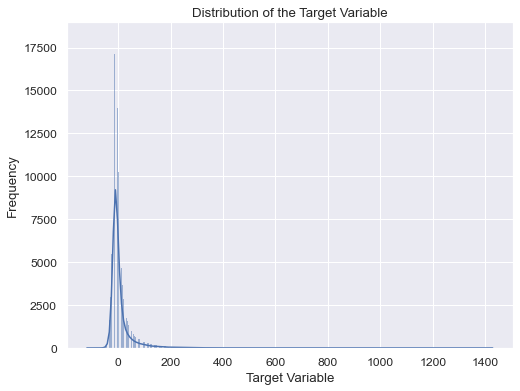

In [23]:
y = df['ArrDelay']
summary_statistics = y.describe()
print(summary_statistics)

# Histogram or kernel density plot
plt.figure(figsize=(8, 6))
sns.histplot(y, kde=True)
plt.title('Distribution of the Target Variable')
plt.xlabel('Target Variable')
plt.ylabel('Frequency')
plt.show()

In [24]:
skewness = y.skew()
print(f'Skewness: {skewness:.2f}')

Skewness: 8.02


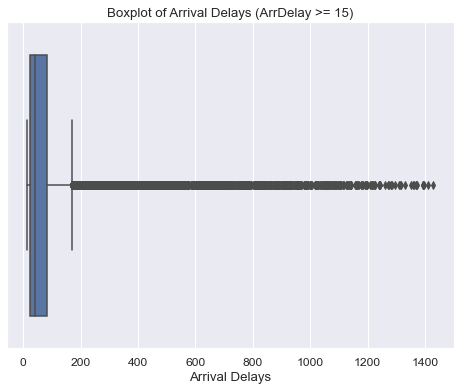

In [25]:
filtered_df = df[df['ArrDelay'] >= 15]

plt.figure(figsize=(8, 6))
sns.boxplot(x=filtered_df['ArrDelay'])

plt.title('Boxplot of Arrival Delays (ArrDelay >= 15)')
plt.xlabel('Arrival Delays')

plt.show()

In [26]:
# transform y to be less skewed and more symmetric
pt = PowerTransformer(method='yeo-johnson', standardize=False)
y_trans = pt.fit_transform(np.array(y).reshape(-1, 1))

Skewness: 0.01


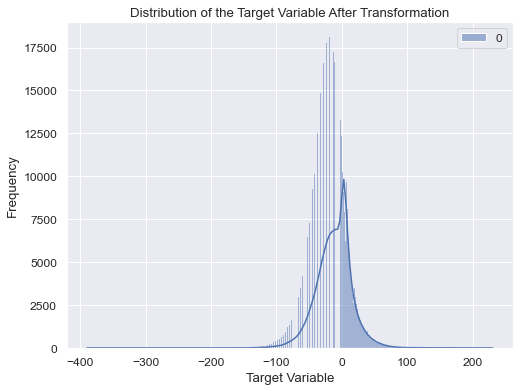

In [27]:
print(f'Skewness: {skew(y_trans.flatten()):.2f}')
# Histogram or kernel density plot
plt.figure(figsize=(8, 6))
sns.histplot(y_trans, kde=True)
plt.title('Distribution of the Target Variable After Transformation')
plt.xlabel('Target Variable')
plt.ylabel('Frequency')
plt.show()

### Auto Feature Selection

In [28]:
#append transformed y to the df
df['y_trans'] = y_trans
df.head()

,Quarter,Month,DayofMonth,Tail_Number,route,DepDelay,DepartureDelayGroups,DepTimeBlk,TaxiOut,TaxiIn,ArrDelay,ArrivalDelayGroups,ArrTimeBlk,TimeDifferenceMinutes_wheels,ActualElapsedTime,AirTime,Distance,DivAirportLandings,y_trans
0,4,12,17,N487UA,LGA-DEN,-3.00,-1,1000-1059,38.00,8.00,-9.00,-1,1200-1259,103.00,269.00,223.00,1620.00,0,-14.56
1,4,12,17,N402UA,EWR-ORD,-7.00,-1,0001-0559,17.00,5.00,-20.00,-2,0600-0659,49.00,131.00,109.00,719.00,0,-39.41
2,4,12,17,N19117,EWR-LAS,-11.00,-1,1000-1059,14.00,7.00,-35.00,-2,1300-1359,109.00,310.00,289.00,2227.00,0,-80.16
3,4,12,17,N415UA,SAN-ORD,-6.00,-1,0800-0859,15.00,14.00,-6.00,-1,1400-1459,332.00,241.00,212.00,1723.00,0,-8.87
4,4,12,17,N61881,BOS-IAD,-1.00,-1,1900-1959,12.00,4.00,-12.00,-1,2100-2159,68.00,84.00,68.00,413.00,0,-20.78


In [29]:
# Split the data into a temporary training set and a holdout test set
X_train_temp, X_test, y_train_temp, y_test = train_test_split(df[num_feats + cat_feats],
                                                              df['y_trans'],
                                                              test_size=0.2,
                                                              #stratify=df['ArrivalDelayGroups'],
                                                              random_state=random_state)

# Split the temporary training set into the final training set and a validation set
X_train, X_val, y_train, y_val = train_test_split(X_train_temp,
                                                  y_train_temp,
                                                  test_size=0.2,
                                                  #stratify=X_train_temp['ArrivalDelayGroups'],
                                                  random_state=random_state)

In [30]:
X_train.head()

,DepDelay,TaxiOut,TaxiIn,TimeDifferenceMinutes_wheels,ActualElapsedTime,AirTime,Distance,DivAirportLandings,Quarter,Month,DayofMonth,Tail_Number,route,DepTimeBlk,ArrTimeBlk
102752,-6.00,10.00,7.00,131.00,148.00,131.00,997.00,0,4,10,14,N14214,TPA-EWR,0700-0759,1000-1059
336081,-8.00,17.00,8.00,131.00,156.00,131.00,937.00,0,2,4,22,N13113,EWR-MCO,1400-1459,1600-1659
56959,-1.00,17.00,5.00,452.00,294.00,272.00,2454.00,0,1,1,22,N589UA,LAX-EWR,1400-1459,2200-2259
518212,-4.00,10.00,7.00,62.00,79.00,62.00,455.00,0,3,8,19,N423UA,BIL-DEN,0600-0659,0700-0759
539679,-7.00,13.00,13.00,292.00,198.00,172.00,1440.00,0,3,8,4,N36444,PHX-ORD,0700-0759,1300-1359


In [31]:
# Calculate Pearson correlation coefficient to eliminate highly related features.
corr_df_num, num_remove_list = CorrelationCalculator.numeric_correlations(X_train,
                                                                          features=num_feats,
                                                                          static_features=None,
                                                                          corr_method='pearson',
                                                                          threshold=0.8)

corr_df_cat, cat_remove_list = CorrelationCalculator.categorical_correlations(X_train,
                                                                              features=cat_feats,
                                                                              static_features=None,
                                                                              threshold=0.8)

In [32]:
num_remove_list

['ActualElapsedTime', 'AirTime']

In [33]:
cat_remove_list

['Quarter']

In [34]:
#Remove correlated features
num_feats_final = [c for c in num_feats if c not in num_remove_list]
cat_feats_final = [c for c in cat_feats if c not in cat_remove_list]

In [35]:
#Create Feature Selector Object
feat_selector = FeatureSelector(modeling_type = 'regression',
                                X_train = X_train, 
                                y_train = y_train,
                                X_test = X_test, 
                                y_test = y_test,
                                numeric_columns = num_feats_final,
                                categorical_columns = cat_feats_final,
                                seed = seed)

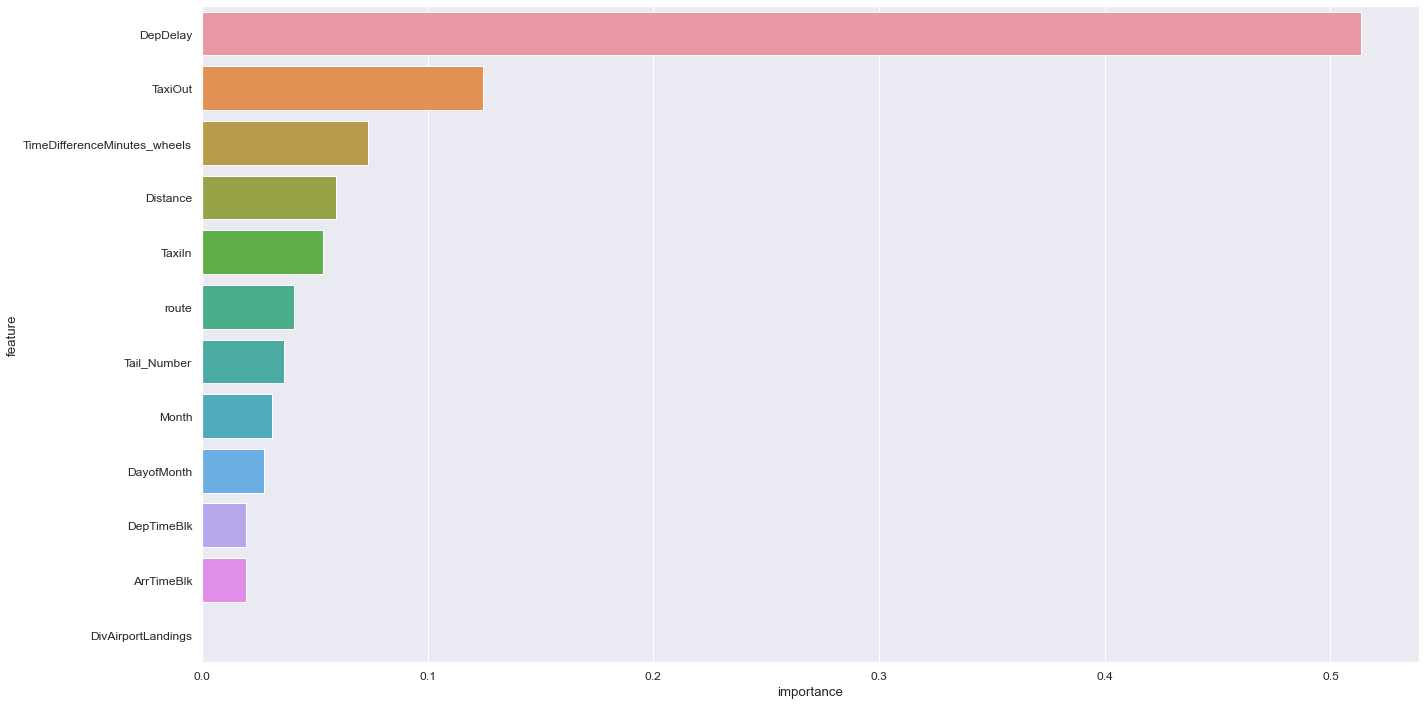

In [36]:
#Calculate feature importance using RandomForest.
rf_importance_df = feat_selector.rf_importance(hyperparam_dict={'n_jobs':n_jobs, 
                                                                'random_state':random_state                                                                
                                                               },
                                               return_plot=True
                                              )



In [37]:
rf_importance_df

,feature,importance
0,DepDelay,0.51
1,TaxiOut,0.12
2,TimeDifferenceMinutes_wheels,0.07
3,Distance,0.06
4,TaxiIn,0.05
5,route,0.04
6,Tail_Number,0.04
7,Month,0.03
8,DayofMonth,0.03
9,DepTimeBlk,0.02


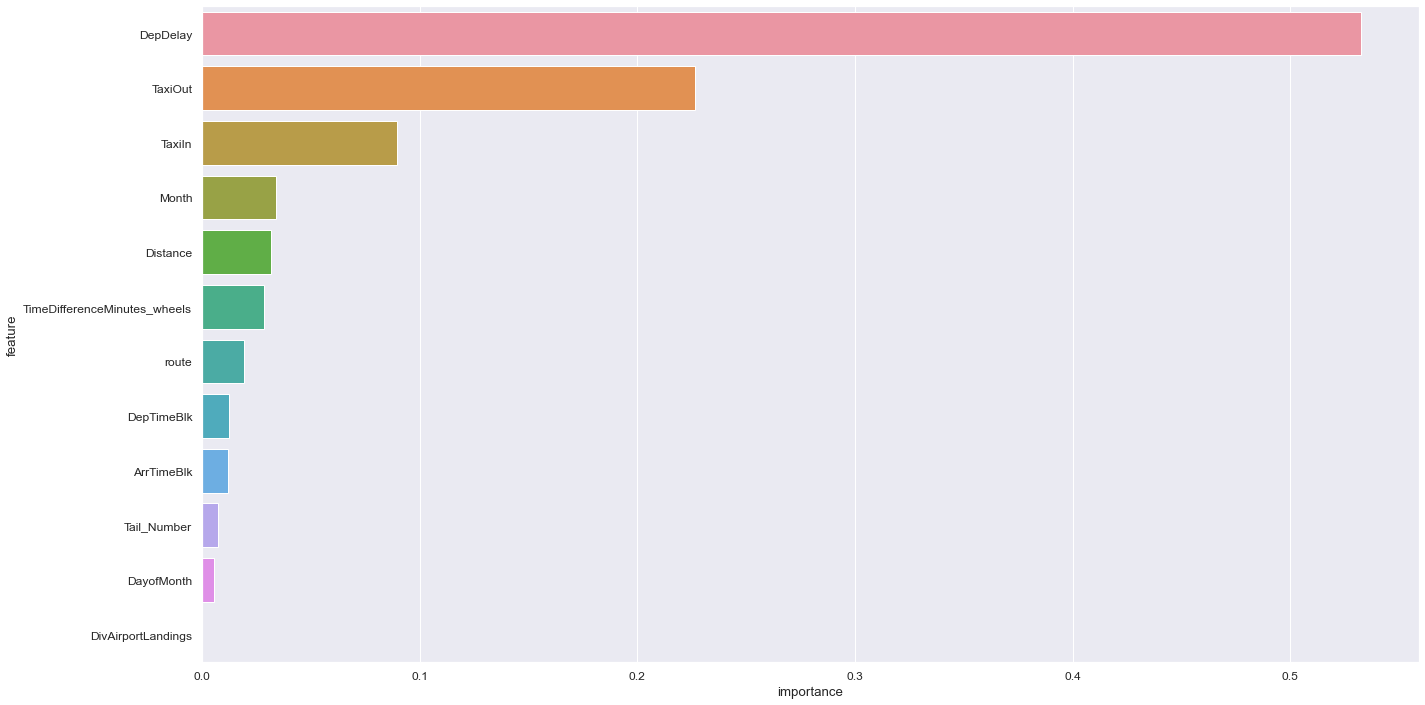

In [38]:
#Calculate feature importance using XGBoost
xgb_importance_df = feat_selector.xgb_importance(hyperparam_dict = {'n_jobs':n_jobs, 'random_state':random_state},
                                                   objective = None,
                                                   return_plot = True
                                                  )

In [39]:
xgb_importance_df

,feature,importance
0,DepDelay,0.53
1,TaxiOut,0.23
2,TaxiIn,0.09
3,Month,0.03
4,Distance,0.03
5,TimeDifferenceMinutes_wheels,0.03
6,route,0.02
7,DepTimeBlk,0.01
8,ArrTimeBlk,0.01
9,Tail_Number,0.01


In [40]:
#Select columns based on the above three feature importance calculations
selected_col = ['DepDelay',
                'Month',
                'route',
                'TaxiOut',
                'TaxiIn',
                'TimeDifferenceMinutes_wheels',                
                'Distance'
               ]

### Lazy Predict

In [41]:
data = df[selected_col]
y = df['y_trans']
X_train, X_test, y_train, y_test = train_test_split(data, y,
                                                    test_size=0.2,
                                                    #stratify=data['ArrivalDelayGroups'],
                                                    random_state=random_state)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (491932, 7)
X_test shape: (122983, 7)


In [42]:
def label_encoder(df):
    lab_encoder = LabelEncoder()
    # Separate numeric and object columns
    object_columns = df.select_dtypes(exclude=[np.number]).columns.tolist()
    for c in object_columns:
        df[c] = lab_encoder.fit_transform(df[c])
    return df

In [43]:
X_train = label_encoder(X_train)
X_test = label_encoder(X_test)

In [44]:
for index, c in enumerate(lazypredict.Supervised.REGRESSORS):
    print(f'Index {index}: {c}')

Index 0: ('AdaBoostRegressor', <class 'sklearn.ensemble._weight_boosting.AdaBoostRegressor'>)
Index 1: ('BaggingRegressor', <class 'sklearn.ensemble._bagging.BaggingRegressor'>)
Index 2: ('BayesianRidge', <class 'sklearn.linear_model._bayes.BayesianRidge'>)
Index 3: ('DecisionTreeRegressor', <class 'sklearn.tree._classes.DecisionTreeRegressor'>)
Index 4: ('DummyRegressor', <class 'sklearn.dummy.DummyRegressor'>)
Index 5: ('ElasticNet', <class 'sklearn.linear_model._coordinate_descent.ElasticNet'>)
Index 6: ('ElasticNetCV', <class 'sklearn.linear_model._coordinate_descent.ElasticNetCV'>)
Index 7: ('ExtraTreeRegressor', <class 'sklearn.tree._classes.ExtraTreeRegressor'>)
Index 8: ('ExtraTreesRegressor', <class 'sklearn.ensemble._forest.ExtraTreesRegressor'>)
Index 9: ('GammaRegressor', <class 'sklearn.linear_model._glm.glm.GammaRegressor'>)
Index 10: ('GaussianProcessRegressor', <class 'sklearn.gaussian_process._gpr.GaussianProcessRegressor'>)
Index 11: ('GradientBoostingRegressor', <cla

In [45]:
regressor_copy = lazypredict.Supervised.REGRESSORS

In [46]:
lazypredict.Supervised.REGRESSORS = [
    regressor_copy[2],
    regressor_copy[5],
    regressor_copy[10],
    regressor_copy[11],
    regressor_copy[13],
    regressor_copy[14], 
    regressor_copy[33],
    regressor_copy[40], 
    regressor_copy[41]
]

In [47]:
clf = LazyRegressor(verbose=0, 
                    ignore_warnings=True, 
                    custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)

models

 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [05:30<01:03, 63.32s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1252
[LightGBM] [Info] Number of data points in the train set: 491932, number of used features: 7
[LightGBM] [Info] Start training from score -11.249645


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [05:33<00:00, 37.03s/it]


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
RandomForestRegressor,0.80,0.80,12.30,244.04
XGBRegressor,0.77,0.77,12.96,3.38
LGBMRegressor,0.74,0.74,13.78,2.37
KNeighborsRegressor,0.71,0.71,14.72,18.58
GradientBoostingRegressor,0.69,0.69,15.09,62.83
BayesianRidge,0.53,0.53,18.69,0.44
HuberRegressor,0.50,0.50,19.23,1.12
ElasticNet,0.46,0.46,20.01,0.31


In [48]:
df[selected_col+['ArrDelay']].to_csv('df_for_model.csv', index=False) #for following model building

https://github.com/shankarpandala/lazypredict/blob/dev/lazypredict/Supervised.py

https://github.com/dorukcanga/AutoFeatSelect/blob/main/autofeatselect/auto_feat_select.py